## Patient Segmentation Objective

The goal of this clustering task is to group patients into cohorts based on
similarity in health indicators.

Similarity is defined using normalized clinical lab measurements such that
patients with comparable organ function and metabolic profiles are grouped
together. The resulting cohorts are intended to support cohort-level
monitoring and risk stratification.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import math
import pickle


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import RobustScaler

## Data preparation and EDA

In [ ]:
import pandas as pd

df_clean = pd.read_csv(r"HealthAI\data\cleaned_data.csv")
print(df_clean.shape)
with pd.option_context('display.max_columns', None):
    display(df_clean.head())

(14622, 48)


,age,gender,residence_type,admission_type,length_of_stay_days,icu_stay_days,smoking_status,alcohol_use,diabetes_mellitus,hypertension,coronary_artery_disease,prior_cardiomyopathy,chronic_kidney_disease,hemoglobin,total_leukocyte_count,platelet_count,glucose_level,urea_level,creatinine_level,raised_cardiac_enzymes,severe_anemia,anemia,stable_angina,acute_coronary_syndrome,st_elevation_myocardial_infarction,atypical_chest_pain,heart_failure,hf_reduced_ejection_fraction,hf_normal_ejection_fraction,valvular_heart_disease,complete_heart_block,sick_sinus_syndrome,acute_kidney_injury,cva_infarct,cva_bleed,atrial_fibrillation,ventricular_tachycardia,paroxysmal_supraventricular_tachycardia,congenital_heart_disease,urinary_tract_infection,neurocardiogenic_syncope,orthostatic_hypotension,infective_endocarditis,deep_vein_thrombosis,cardiogenic_shock,shock,pulmonary_embolism,chest_infection
0,81,M,R,E,3,2,0,0,1,0,0,0,0,9.5,16.1,337.0,80.0,34.0,0.90,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,65,M,R,E,5,2,0,1,0,1,1,0,0,13.7,9.0,149.0,112.0,18.0,0.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,53,M,U,E,3,3,0,0,1,0,1,0,0,10.6,14.7,329.0,187.0,93.0,2.30,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,67,F,U,E,8,6,0,0,0,1,1,0,0,12.8,9.9,286.0,130.0,27.0,0.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,60,F,U,E,23,9,0,0,0,1,0,1,0,13.6,9.1,26.0,144.0,55.0,1.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
print(df_clean.columns.tolist())

['age', 'gender', 'residence_type', 'admission_type', 'length_of_stay_days', 'icu_stay_days', 'smoking_status', 'alcohol_use', 'diabetes_mellitus', 'hypertension', 'coronary_artery_disease', 'prior_cardiomyopathy', 'chronic_kidney_disease', 'hemoglobin', 'total_leukocyte_count', 'platelet_count', 'glucose_level', 'urea_level', 'creatinine_level', 'raised_cardiac_enzymes', 'severe_anemia', 'anemia', 'stable_angina', 'acute_coronary_syndrome', 'st_elevation_myocardial_infarction', 'atypical_chest_pain', 'heart_failure', 'hf_reduced_ejection_fraction', 'hf_normal_ejection_fraction', 'valvular_heart_disease', 'complete_heart_block', 'sick_sinus_syndrome', 'acute_kidney_injury', 'cva_infarct', 'cva_bleed', 'atrial_fibrillation', 'ventricular_tachycardia', 'paroxysmal_supraventricular_tachycardia', 'congenital_heart_disease', 'urinary_tract_infection', 'neurocardiogenic_syncope', 'orthostatic_hypotension', 'infective_endocarditis', 'deep_vein_thrombosis', 'cardiogenic_shock', 'shock', 'pulmo

In [ ]:
meta_df = pd.read_csv(r"HealthAI\data\meta_data.csv")
meta_df["modified_as_column_name"] = meta_df["modified_as_column_name"].str.strip()

cat_meta = meta_df[
    meta_df["modified_as_column_name"].isin(df_clean.columns)
][["modified_as_column_name", "Data Category"]]

# Reset index for clean display
cat_meta = cat_meta.reset_index(drop=True)

print(cat_meta.to_string(index=False))


                modified_as_column_name                        Data Category
                                    age                          Demographic
                                 gender                          Demographic
                         residence_type                          Demographic
                         admission_type             Admission / Care Pathway
                    length_of_stay_days                Outcome / Utilization
                          icu_stay_days                Outcome / Utilization
                         smoking_status          Lifestyle / Behavioral Risk
                            alcohol_use          Lifestyle / Behavioral Risk
                      diabetes_mellitus        Chronic Disease / Comorbidity
                           hypertension        Chronic Disease / Comorbidity
                coronary_artery_disease        Chronic Disease / Comorbidity
                   prior_cardiomyopathy        Chronic Disease / Comorbidity

### Define Feature Groups for Clustering

In [5]:
# Health (used for clustering)
cluster_features = [
    "age",
    "hemoglobin",
    "total_leukocyte_count",
    "platelet_count",
    "glucose_level",
    "creatinine_level",
    "urea_level"
]

# Behavior (for interpretation only)
behavior_features = [
    "smoking_status",
    "alcohol_use",
]

# Disease indicators (for interpretation only)
disease_features = [
    "diabetes_mellitus",
    "hypertension",
    "coronary_artery_disease",
    "chronic_kidney_disease"
]

In [6]:
prevalence_features = behavior_features + disease_features

prevalence = (
    df_clean[prevalence_features].mean().mul(100).round(2)
)

prevalence

smoking_status              5.03
alcohol_use                 6.61
diabetes_mellitus          32.49
hypertension               49.11
coronary_artery_disease    68.38
chronic_kidney_disease      9.40
dtype: float64

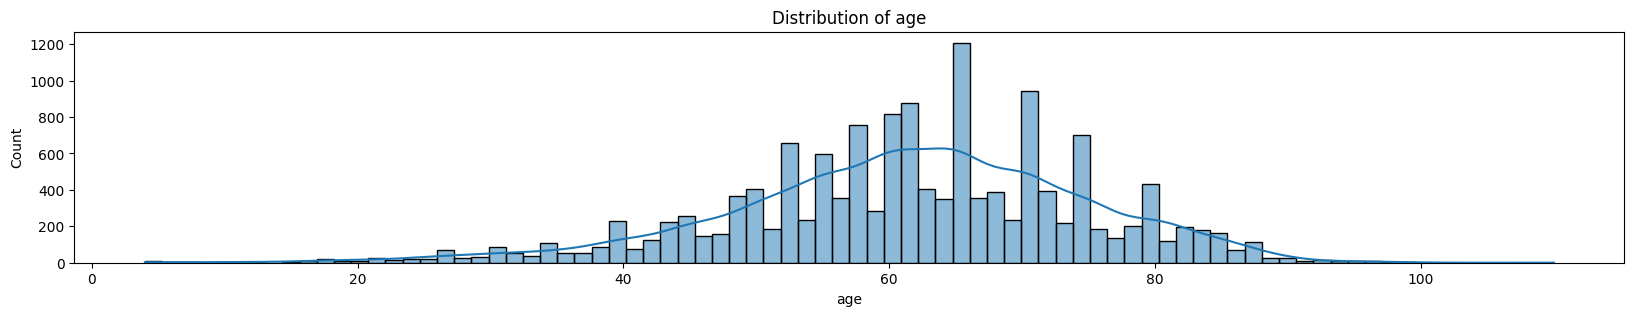

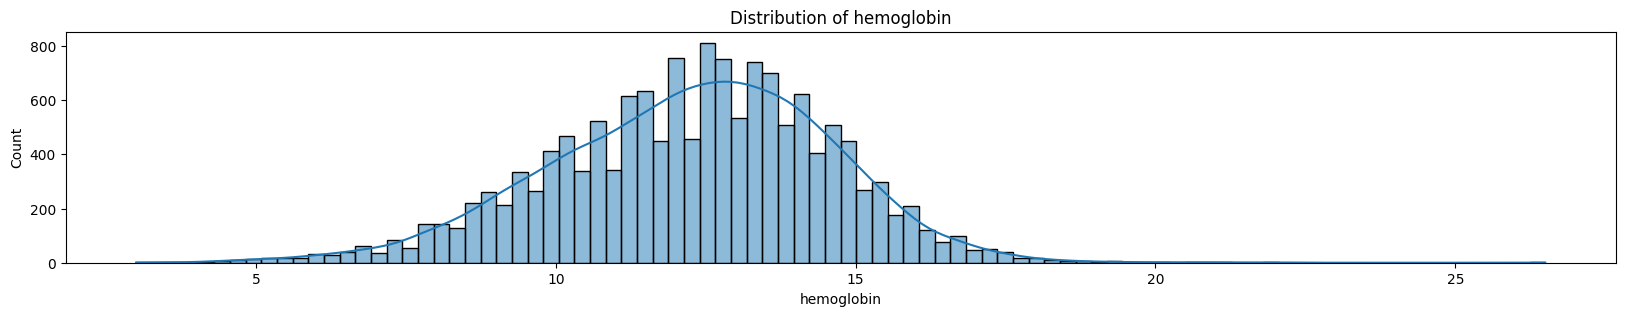

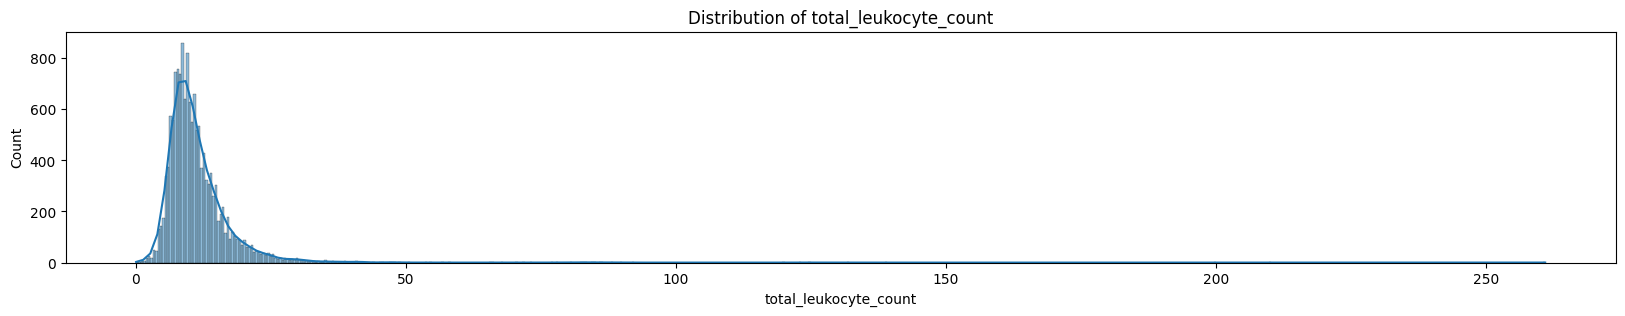

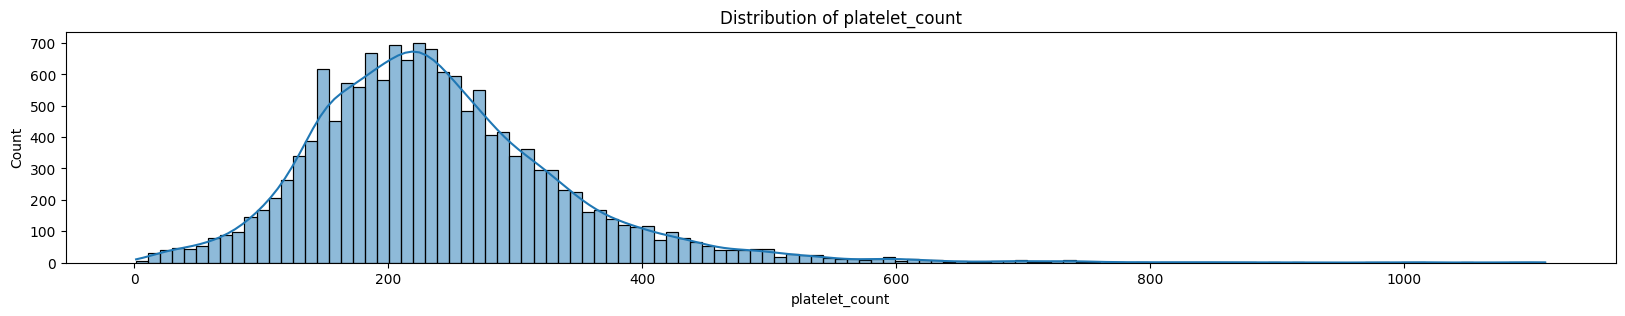

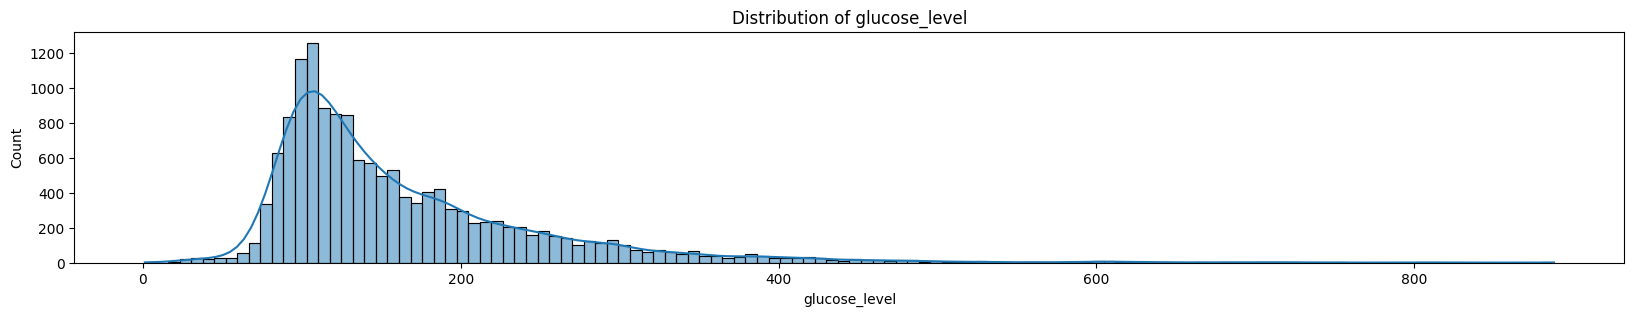

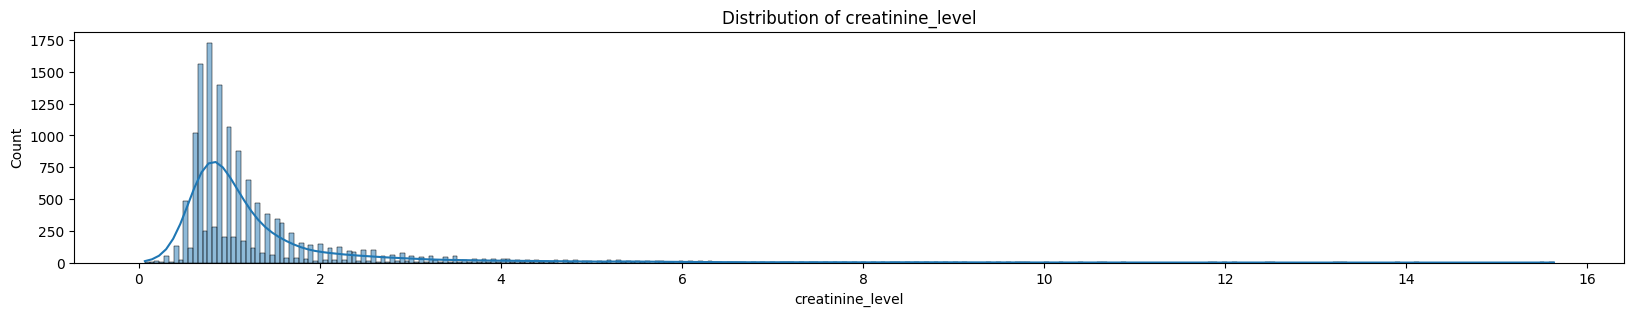

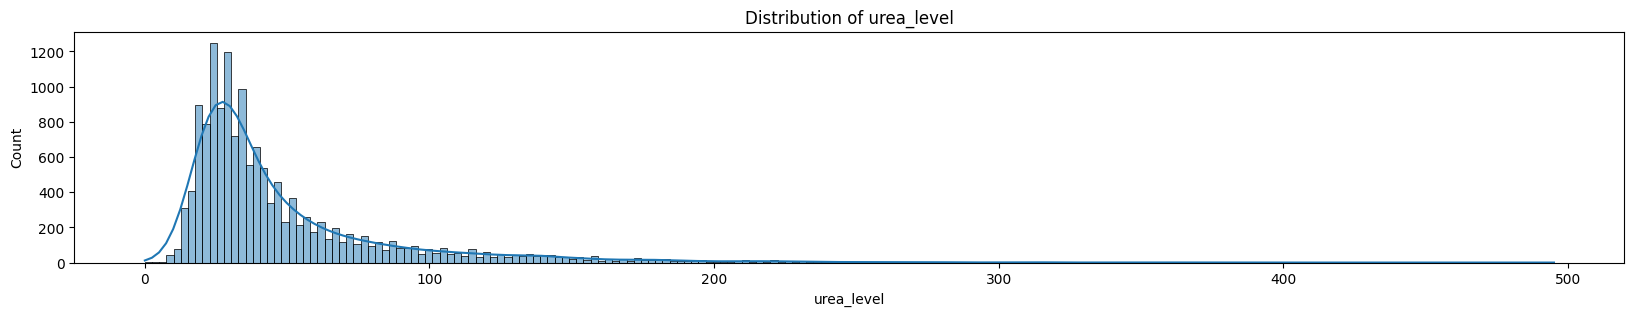

In [7]:
for col in cluster_features:
    plt.figure(figsize=(20,3))
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


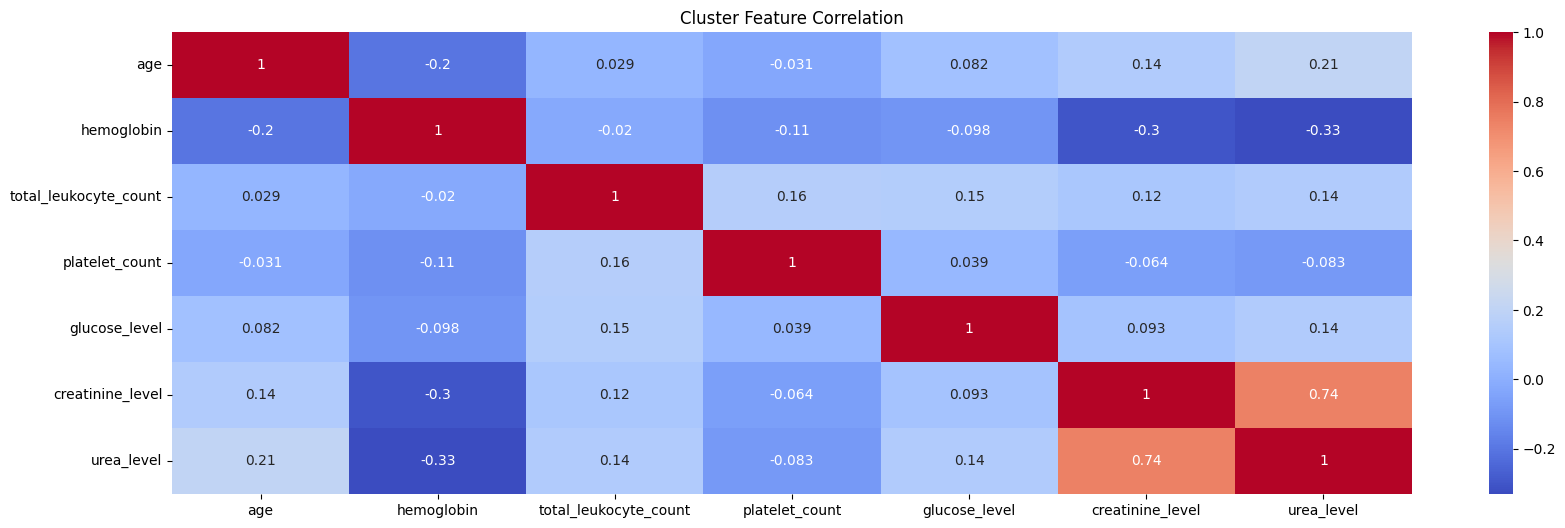

In [8]:
plt.figure(figsize=(20,6))
sns.heatmap(df_clean[cluster_features].corr(), annot=True, cmap="coolwarm")
plt.title("Cluster Feature Correlation")
plt.show()

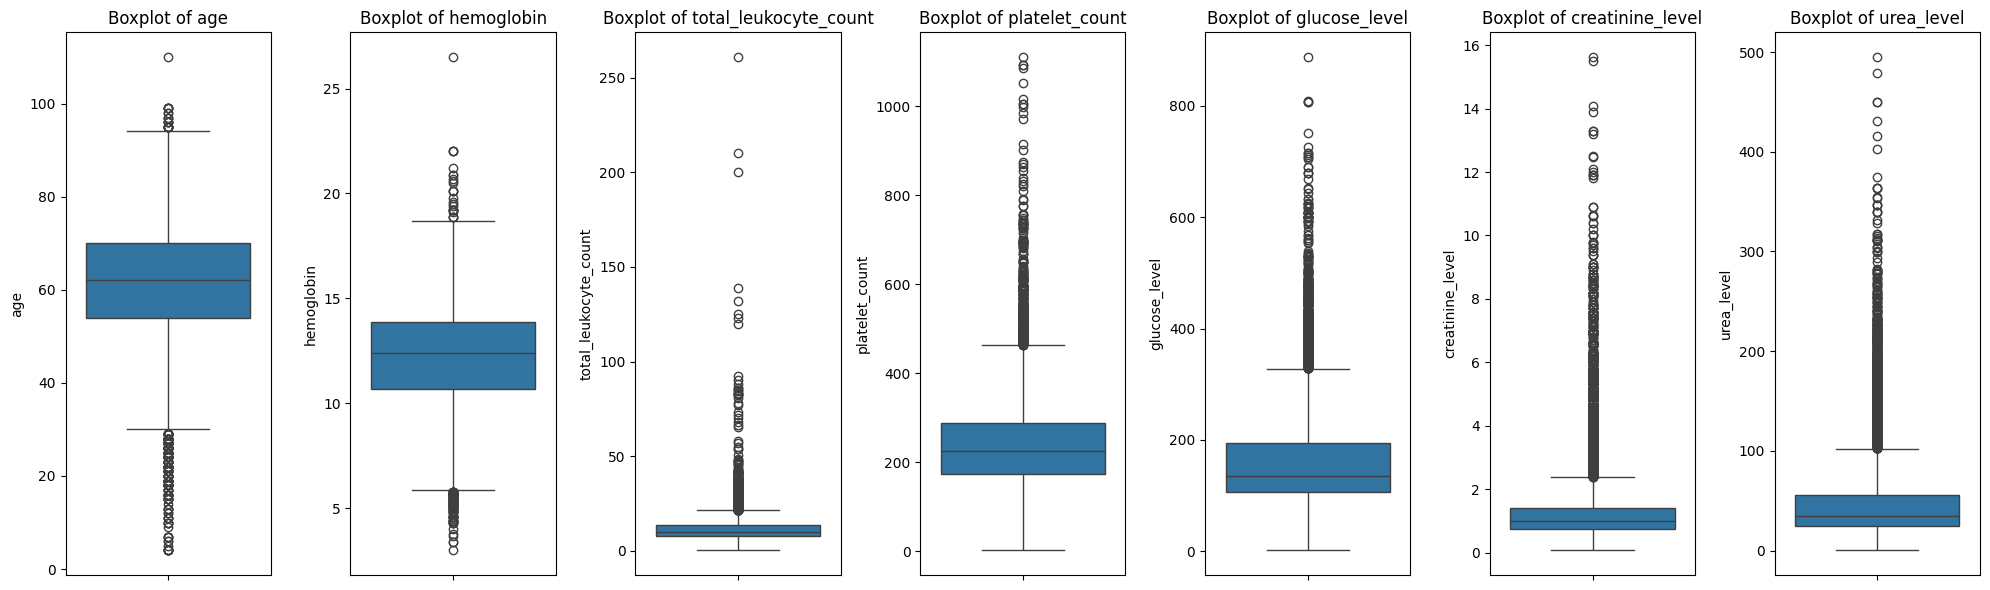

In [9]:
n = len(cluster_features)
cols = 7

# Auto-calc rows
rows = math.ceil(n / cols)

# Auto figure size (height grows with rows)
plt.figure(figsize=(20, rows * 6))

for i, col in enumerate(cluster_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(data=df_clean[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [10]:
disease_features = [
    "diabetes_mellitus",
    "hypertension",
    "coronary_artery_disease",
    "chronic_kidney_disease"
]

df_clean[disease_features].mean()

diabetes_mellitus          0.324921
hypertension               0.491109
coronary_artery_disease    0.683764
chronic_kidney_disease     0.093968
dtype: float64

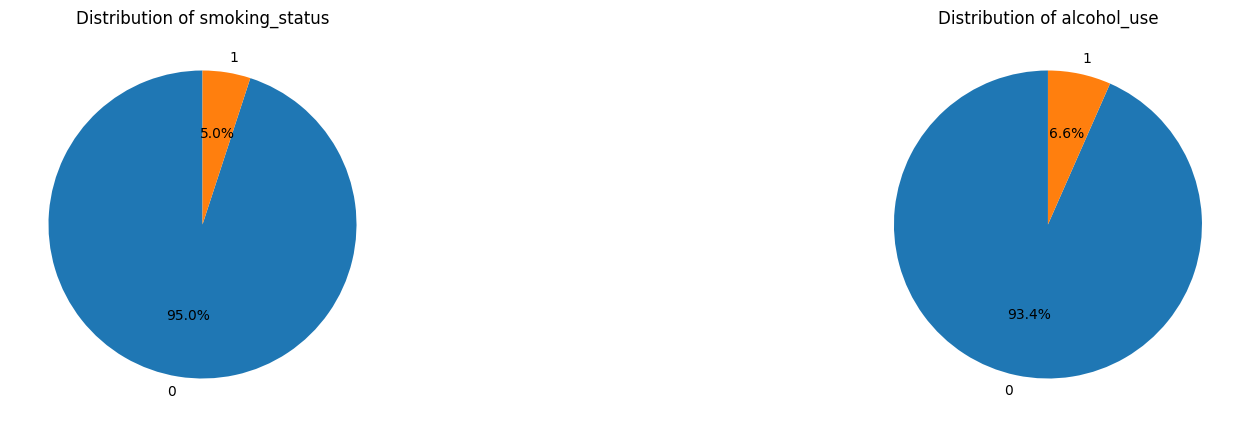

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for ax, col in zip(axes, behavior_features):
    df_clean[col].value_counts().plot(
        kind="pie",
        autopct="%.1f%%",
        startangle=90,
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_ylabel("")
plt.show()

### Scale Numerical Features Using RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clean[cluster_features])

# Save the fitted scaler
with open("HealthAI\models\patient_segmentation\segment_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

### Fit KMeans Clustering Model

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_clean["cluster"] = labels

In [14]:
import numpy as np

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 10891, 1: 631, 2: 3100}

### Evaluate Clustering Performance

In [15]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

sil_score = silhouette_score(X_scaled, labels)
db_score = davies_bouldin_score(X_scaled, labels)

print("Silhouette Score:", round(sil_score, 3))
print("Davies-Bouldin Index:", round(db_score, 3))


Silhouette Score: 0.339
Davies-Bouldin Index: 1.431


Model stability

In [16]:
from sklearn.metrics import adjusted_rand_score

labels1 = KMeans(3, random_state=42).fit_predict(X_scaled)
labels2 = KMeans(3, random_state=99).fit_predict(X_scaled)

adjusted_rand_score(labels1, labels2)

0.9988355973752729

### Behavioral Feature Distribution

In [17]:
cluster_profile = (
    df_clean
    .groupby("cluster")[cluster_features + behavior_features + disease_features]
    .mean()
    .round(2)
)

cluster_profile

,age,hemoglobin,total_leukocyte_count,platelet_count,glucose_level,creatinine_level,urea_level,smoking_status,alcohol_use,diabetes_mellitus,hypertension,coronary_artery_disease,chronic_kidney_disease
cluster,,,,,,,,,,,,,
0,59.64,12.72,10.17,240.64,148.67,0.89,32.03,0.06,0.07,0.28,0.47,0.69,0.00
1,63.97,9.75,12.84,222.60,176.75,5.68,166.76,0.03,0.05,0.45,0.64,0.67,0.99
2,67.07,11.10,15.42,240.25,208.96,1.95,84.96,0.04,0.05,0.46,0.54,0.67,0.22


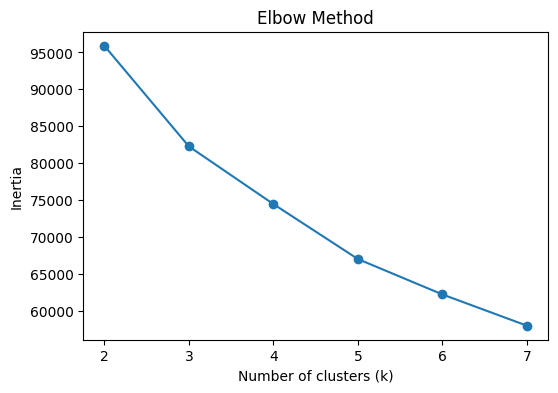

In [18]:
inertia = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [19]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

In [20]:
import numpy as np

unique, counts = np.unique(dbscan_labels, return_counts=True)
dict(zip(unique, counts))

{-1: 783, 0: 13824, 1: 15}

In [ ]:
import pickle

model_path = r"HealthAI\models\patient_segmentation\segmentation-kmeans_model.pkl"

with open(model_path, "wb") as file:
    pickle.dump(kmeans, file)
    
print("Model saved successfully as:", model_path)